# Visual Odometry for Localization in Autonomous Driving
Based on project 2 of "Visual Perception for Self-Driving Cars" from University of Toronto in Coursera.

This project estimates a car's trajectory using 52 images taken by a camera on the car and visual odometry. The images are taken using the CARLA simulator. The car's trajectory is estimated by:
1. Extracting ORB features from each image.
2. Matching features between consecutive images.
3. Estimating the camera motion using the matched features to estiamate the Essential matrix
4. Use estimated camera motion to build the trajectory


In [9]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from m2bk import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
dataset_handler = DatasetHandler()  # loads images and camera calibration matrix k. Depth maps available but not used

Data loading: 0%
Data loading: 0%
Data loading: 0%
Data loading: 0%
Data loading: 0%
Data loading: 0%
Data loading: 0%
Data loading: 0%
Data loading: 0%
Data loading: 0%
Data loading: 0%
Data loading: 0%
Data loading: 0%
Data loading: 0%
Data loading: 0%
Data loading: 0%
Data loading: 0%
Data loading: 0%
Data loading: 0%
Data loading: 0%
Data loading: 0%
Data loading: 0%
Data loading: 0%
Data loading: 0%
Data loading: 0%
Data loading: 0%
Data loading: 0%
Data loading: 0%
Data loading: 0%
Data loading: 0%
Data loading: 0%
Data loading: 0%
Data loading: 0%
Data loading: 0%
Data loading: 0%
Data loading: 0%
Data loading: 0%
Data loading: 0%
Data loading: 0%
Data loading: 0%
Data loading: 0%
Data loading: 0%
Data loading: 0%
Data loading: 0%
Data loading: 0%
Data loading: 0%
Data loading: 0%
Data loading: 0%
Data loading: 0%
Data loading: 0%
Data loading: 0%
Data loading: 0%
Data loading: 0%
Data loading: 0%
Data loading: 0%
Data loading: 0%
Data loading: 0%
Data loading: 0%
Data loading: 

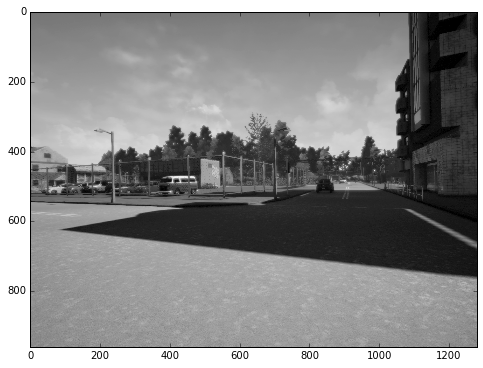

In [11]:
image = dataset_handler.images[0]  # sample image

plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(image, cmap='gray')

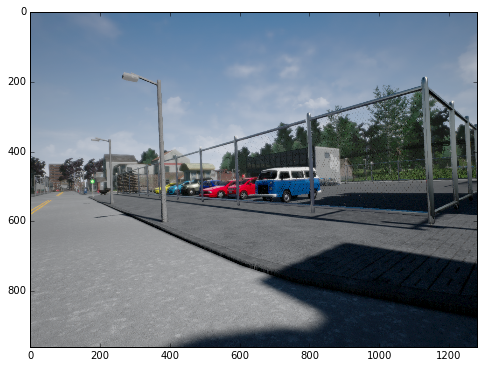

In [12]:
image_rgb = dataset_handler.images_rgb[30]

plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(image_rgb)

In [16]:
dataset_handler.k  # camera matrix

array([[640.,   0., 640.],
       [  0., 480., 480.],
       [  0.,   0.,   1.]], dtype=float32)

## 1 - Feature Extraction

### 1.1 - Extracting Features from an Image

ORB Image features extracted with opencv function ORB_create() and detectAndCompute()

  [OpenCV:Feature Detection and Description](https://docs.opencv.org/3.4.3/db/d27/tutorial_py_table_of_contents_feature2d.html). 

In [17]:
def extract_features(image):
    """
    Find keypoints and descriptors for the image

    Arguments:
    image -- a grayscale image

    Returns:
    kp -- list of the extracted keypoints (features) in an image
    des -- list of the keypoint descriptors in an image
    """
    
    orb = cv2.ORB_create()
    kp, des = orb.detectAndCompute(image,None)

    
   
    
    return kp, des

In [18]:
i = 0
image = dataset_handler.images[i]
kp, des = extract_features(image)
print("Number of features detected in frame {0}: {1}\n".format(i, len(kp)))

print("Coordinates of the first keypoint in frame {0}: {1}".format(i, str(kp[0].pt)))

Number of features detected in frame 0: 500

Coordinates of the first keypoint in frame 0: (911.0, 437.0)


In [19]:
def visualize_features(image, kp):
    """
    Visualize extracted features in the image

    Arguments:
    image -- a grayscale image
    kp -- list of the extracted keypoints

    Returns:
    """
    display = cv2.drawKeypoints(image, kp, None,color=(0,255,0))
    plt.imshow(display)

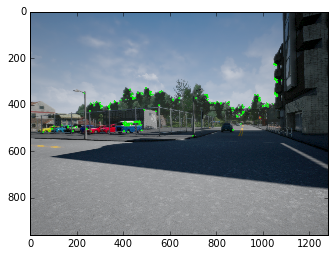

In [20]:
# Optional: visualizing and experimenting with various feature descriptors
i = 0
image = dataset_handler.images_rgb[i]

visualize_features(image, kp)

### 1.2 - Extract Features from Each Image in the Dataset



In [21]:
def extract_features_dataset(images, extract_features_function):
    """
    Find keypoints and descriptors for each image in the dataset

    Arguments:
    images -- a list of grayscale images
    extract_features_function -- a function which finds features (keypoints and descriptors) for an image

    Returns:
    kp_list -- a list of keypoints for each image in images
    des_list -- a list of descriptors for each image in images
    
    """
    kp_list = []
    des_list = []
    
    
    for img in images:
        kp,des = extract_features_function(img)
        kp_list.append(kp)
        des_list.append(des)

    
    
    
    return kp_list, des_list

In [22]:
images = dataset_handler.images
kp_list, des_list = extract_features_dataset(images, extract_features)

i = 0
print("Number of features detected in frame {0}: {1}".format(i, len(kp_list[i])))
print(len(des_list[0]))
print("Coordinates of the first keypoint in frame {0}: {1}\n".format(i, str(kp_list[i][0].pt)))

# Remember that the length of the returned by dataset_handler lists should be the same as the length of the image array
print("Length of images array: {0}".format(len(images)))

Number of features detected in frame 0: 500
500
Coordinates of the first keypoint in frame 0: (911.0, 437.0)

Length of images array: 52


## 2 - Feature Matching

Match the features from the subsequent frames. 

### 2.1 - Matching Features from a Pair of Subsequent Frames

Use brute force matcher to find 2 nearest neighbors to each feature. Then filter matches using a ratio threshold.

In [23]:
def match_features(des1, des2):
    """
    Match features from two images

    Arguments:
    des1 -- list of the keypoint descriptors in the first image
    des2 -- list of the keypoint descriptors in the second image

    Returns:
    match -- list of matched features from two images. Each match[i] is k or less matches for the same query descriptor
    """
    
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
    match = bf.knnMatch(des1,des2,k=2)
  

    return match

In [25]:
i = 0 
des1 = des_list[i]
des2 = des_list[i+1]

match = match_features(des1, des2)
print("Number of features matched in frames {0} and {1}: {2}".format(i, i+1, len(match)))
#print(match[0].trainIdx,match[0].imgIdx,kp1[match[0].trainIdx].pt)
print(len(des1),len(des2))


Number of features matched in frames 0 and 1: 500
(500, 500)


In [30]:

def filter_matches_distance(match, dist_threshold):
    """
    Filter matched features from two images by distance between the best matches

    Arguments:
    match -- list of matched features from two images
    dist_threshold -- maximum allowed relative distance between the best matches, (0.0, 1.0) 

    Returns:
    filtered_match -- list of good matches, satisfying the distance threshold
    """
    filtered_match = []
    
  
    
    for m,n in match:
        if m.distance < dist_threshold*n.distance:
            filtered_match.append(m)
    
 

    return filtered_match

In [31]:
# Filter the matches
i = 0 
des1 = des_list[i]
des2 = des_list[i+1]
print("num des1,des2  ", len(des1), len(des2))
match = match_features(des1, des2)

dist_threshold = 0.6
filtered_match = filter_matches_distance(match, dist_threshold)

print("Number of features matched in frames {0} and {1} after filtering by distance: {2}".format(i, i+1, len(filtered_match)))

('num des1,des2  ', 500, 500)
Number of features matched in frames 0 and 1 after filtering by distance: 218


In [32]:
def visualize_matches(image1, kp1, image2, kp2, match):
    """
    Visualize corresponding matches in two images

    Arguments:
    image1 -- the first image in a matched image pair
    kp1 -- list of the keypoints in the first image
    image2 -- the second image in a matched image pair
    kp2 -- list of the keypoints in the second image
    match -- list of matched features from the pair of images

    Returns:
    image_matches -- an image showing the corresponding matches on both image1 and image2 or None if you don't use this function
    """
    image_matches = cv2.drawMatches(image1,kp1,image2,kp2,match,None,flags=2)
    plt.figure(figsize=(16, 6), dpi=100)
    plt.imshow(image_matches)

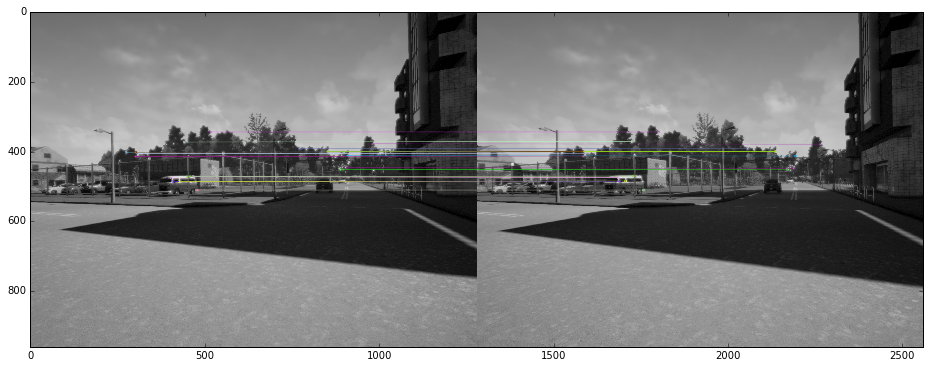

In [33]:
# Visualize n first matches, 
# set filtering to True if using match filtering, otherwise set to False
n = 20
filtering = True

i = 0 
image1 = dataset_handler.images[i]
image2 = dataset_handler.images[i+1]

kp1 = kp_list[i]
kp2 = kp_list[i+1]

des1 = des_list[i]
des2 = des_list[i+1]

match = match_features(des1, des2)
if filtering:
    dist_threshold = 0.6
    match = filter_matches_distance(match, dist_threshold)

image_matches = visualize_matches(image1, kp1, image2, kp2, match[:n])    

### 2.2 - Match Features in Each Subsequent Image Pair in the Dataset



In [35]:
def match_features_dataset(des_list, match_features):
    """
    Match features for each subsequent image pair in the dataset

    Arguments:
    des_list -- a list of descriptors for each image in the dataset
    match_features -- a function which maches features between a pair of images

    Returns:
    matches -- list of matches for each subsequent image pair in the dataset. 
               Each matches[i] is a list of matched features from images i and i + 1
               
    """
    matches = []
    
    
    N = len(des_list)
    for i in range(N-1):
        des1 = des_list[i]
        des2 = des_list[i+1]

        match = match_features(des1, des2)
        matches.append(match)
    
    
    
    return matches

In [36]:
matches = match_features_dataset(des_list, match_features)

i = 0
print("Number of features matched in frames {0} and {1}: {2}".format(i, i+1, len(matches[i])))

Number of features matched in frames 0 and 1: 500


In [37]:

def filter_matches_dataset(filter_matches_distance, matches, dist_threshold):
    """
    Filter matched features by distance for each subsequent image pair in the dataset

    Arguments:
    filter_matches_distance -- a function which filters matched features from two images by distance between the best matches
    matches -- list of matches for each subsequent image pair in the dataset. 
               Each matches[i] is a list of matched features from images i and i + 1
    dist_threshold -- maximum allowed relative distance between the best matches, (0.0, 1.0) 

    Returns:
    filtered_matches -- list of good matches for each subsequent image pair in the dataset. 
                        Each matches[i] is a list of good matches, satisfying the distance threshold
               
    """
    filtered_matches = []
    
    ### START CODE HERE ###
    for match in matches:
        filtered_match = filter_matches_distance(match, dist_threshold)
        filtered_matches.append(filtered_match)


    
    ### END CODE HERE ###
    
    return filtered_matches

In [39]:

dist_threshold = 0.6

filtered_matches = filter_matches_dataset(filter_matches_distance, matches, dist_threshold)

if len(filtered_matches) > 0:
    
    # Make sure that this variable is set to True if you want to use filtered matches further in your assignment
    is_main_filtered_m = True
    if is_main_filtered_m: 
        matches = filtered_matches

    i = 0
    print("Number of filtered matches in frames {0} and {1}: {2}".format(i, i+1, len(filtered_matches[i])))

Number of filtered matches in frames 0 and 1: 218


## 3 - Trajectory Estimation

This section incrementally estimates the pose of the vehicle by examining the changes that motion induces on the images of its onboard camera.

### 3.1 - Estimating Camera Motion between a Pair of Images

Matching features are used to estimate the Essential matrix using opencv function findEssentialMat(). The camera motion is estimated using the function recoverPose() with the Essential matrix as input. These estimate a rotation matrix rmat and translation vector tvec that transform coordinates from one frame to the next.

r(k+1) = [rmat|tvec]r[k] = Tk r(k)

For trajectory estimation, the inverse of Tk is needed
r(k) = inv(Tk) r(k+1)

More information on both approaches implementation can be found in [OpenCV: Camera Calibration and 3D Reconstruction](https://docs.opencv.org/3.4.3/d9/d0c/group__calib3d.html). Specifically, you might be interested in _Detailed Description_ section of [OpenCV: Camera Calibration and 3D Reconstruction](https://docs.opencv.org/3.4.3/d9/d0c/group__calib3d.html) as it explains the connection between the 3D world coordinate system and the 2D image coordinate system.



In [44]:
def estimate_motion(match, kp1, kp2, k, depth1=None):
    """
    Estimate camera motion from a pair of subsequent image frames

    Arguments:
    match -- list of matched features from the pair of images
    kp1 -- list of the keypoints in the first image
    kp2 -- list of the keypoints in the second image
    k -- camera calibration matrix 
    
    Optional arguments:
    depth1 -- a depth map of the first frame. This argument is not needed if you use Essential Matrix Decomposition

    Returns:
    rmat -- recovered 3x3 rotation numpy matrix
    tvec -- recovered 3x1 translation numpy vector
    image1_points -- a list of selected match coordinates in the first image. image1_points[i] = [u, v], where u and v are 
                     coordinates of the i-th match in the image coordinate system
    image2_points -- a list of selected match coordinates in the second image. image1_points[i] = [u, v], where u and v are 
                     coordinates of the i-th match in the image coordinate system
               
    """
    rmat = np.eye(3)
    tvec = np.zeros((3, 1))
    image1_points = []
    image2_points = []
    
   
   
    #print(match.trainIdx)
    for m in match:
        pt2 = kp2[m.trainIdx].pt
        pt1 = kp1[m.queryIdx].pt
        
        image1_points.append([pt1[0],pt1[1]]) 
        image2_points.append([pt2[0],pt2[1]]) 
    points1 = np.array(image1_points).astype(np.float32)
    points2 = np.array(image2_points).astype(np.float32)
    E,mask = cv2.findEssentialMat(points1,points2,k,cv2.RANSAC)
    #print E
    retval, rmat, tvec,mask = cv2.recoverPose(E,points1,points2,k,900,mask)
    
    return rmat, tvec, image1_points, image2_points

In [46]:
i = 0
#match = matches[i]
kp1 = kp_list[i]
kp2 = kp_list[i+1]
k = dataset_handler.k


rmat, tvec, image1_points, image2_points = estimate_motion(match, kp1, kp2, k)

print("Estimated rotation:\n {0}".format(rmat))
print("Estimated translation:\n {0}".format(tvec))

Estimated rotation:
 [[ 9.99974133e-01 -7.19248392e-03 -3.48187864e-05]
 [ 7.19247326e-03  9.99974090e-01 -2.97159126e-04]
 [ 3.69551964e-05  2.96901006e-04  9.99999955e-01]]
Estimated translation:
 [[ 0.30440484]
 [ 0.01541015]
 [-0.95241809]]


**Camera Movement Visualization**:
You can use `visualize_camera_movement` that is provided to you. This function visualizes final image matches from an image pair connected with an arrow corresponding to direction of camera movement (when `is_show_img_after_mov = False`). The function description:
```
Arguments:
image1 -- the first image in a matched image pair (RGB or grayscale)
image1_points -- a list of selected match coordinates in the first image. image1_points[i] = [x, y], where x and y are 
                 coordinates of the i-th match in the image coordinate system
image2 -- the second image in a matched image pair (RGB or grayscale)
image2_points -- a list of selected match coordinates in the second image. image1_points[i] = [x, y], where x and y are 
                 coordinates of the i-th match in the image coordinate system
is_show_img_after_mov -- a boolean variable, controling the output (read image_move description for more info) 

Returns:
image_move -- an image with the visualization. When is_show_img_after_mov=False then the image points from both images are visualized on the first image. Otherwise, the image points from the second image only are visualized on the second image
```

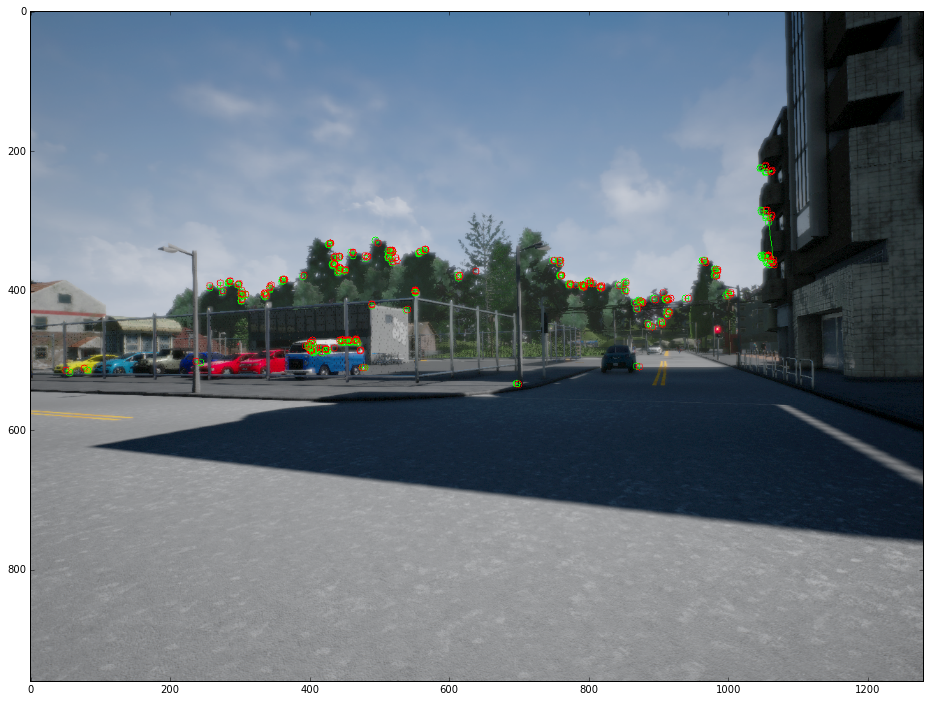

In [47]:
i=0
image1  = dataset_handler.images_rgb[i]
image2 = dataset_handler.images_rgb[i + 1]

image_move = visualize_camera_movement(image1, image1_points, image2, image2_points)
plt.figure(figsize=(16, 12), dpi=100)
plt.imshow(image_move)

### 3.2 - Camera Trajectory Estimation

Trajectory estimated with visual odometry. The trajectory starts at 0. Camera motion is estimated for each frame. This estimates a rotation matrix and translation vector to go from frame k to frame k+1. In homogeneous coodinates, this is a matrix multiplication by operator Tk
r(k+1) = Tk r(k)

The camera is at the origin in frame k+1. Its coordinats in frame k are given by
c(k) = inv(Tk) c(k+1)
The transformations are accumulated to express the camera coordinates in the original frame.
c(0) = inv(T1)...inv(Tk) c(k+1)



In [53]:
def estimate_trajectory(estimate_motion, matches, kp_list, k, depth_maps=[]):
    """
    Estimate complete camera trajectory from subsequent image pairs

    Arguments:
    estimate_motion -- a function which estimates camera motion from a pair of subsequent image frames
    matches -- list of matches for each subsequent image pair in the dataset. 
               Each matches[i] is a list of matched features from images i and i + 1
    des_list -- a list of keypoints for each image in the dataset
    k -- camera calibration matrix 
    
    Optional arguments:
    depth_maps -- a list of depth maps for each frame. This argument is not needed if you use Essential Matrix Decomposition

    Returns:
    trajectory -- a 3xlen numpy array of the camera locations, where len is the lenght of the list of images and   
                  trajectory[:, i] is a 3x1 numpy vector, such as:
                  
                  trajectory[:, i][0] - is X coordinate of the i-th location
                  trajectory[:, i][1] - is Y coordinate of the i-th location
                  trajectory[:, i][2] - is Z coordinate of the i-th location
                  
                  * Consider that the origin of your trajectory cordinate system is located at the camera position 
                  when the first image (the one with index 0) was taken. The first camera location (index = 0) is geven 
                  at the initialization of this function

    """
    N = len(kp_list)
    trajectory = np.zeros((3, N))
    Tprev = np.eye(4)
    c  = np.array([0.,0.,0.,1.])  # helper vectors
    c = np.reshape(c,(4,1))
    #cam  = np.ones((4,1))
    
    
    for i in range(N-1):
        kp1 = kp_list[i]
        kp2 = kp_list[i+1]
        
        match = matches[i]
        
        rmat, tvec, image1_points, image2_points = estimate_motion(match, kp1, kp2, k)
       
        #print(rmat)
        #print(tvec)
              
       
        T = np.concatenate((rmat,tvec),axis=1)
        T = np.concatenate((T,c.T),axis=0)
        Ti = np.linalg.inv(T)
        
        Tprev = np.dot(Tprev,Ti)
        cnew = np.dot(Tprev,c)
        trajectory[:,i+1] = np.squeeze(cnew[:3])
   
    return trajectory

In [54]:

trajectory = estimate_trajectory(estimate_motion, matches, kp_list, k)

i = 1
print("Camera location in point {0} is: \n {1}\n".format(i, trajectory[:, [i]]))

# Remember that the length of the returned by trajectory should be the same as the length of the image array
print("Length of trajectory: {0}".format(trajectory.shape[1]))

Camera location in point 1 is: 
 [[-0.30447261]
 [-0.01293755]
 [ 0.95243323]]

Length of trajectory: 52


In [57]:
# Note: Make sure to uncomment the below line if you modified the original data in any ways
#dataset_handler = DatasetHandler()


# Part 1. Features Extraction
images = dataset_handler.images
kp_list, des_list = extract_features_dataset(images, extract_features)


# Part II. Feature Matching
matches = match_features_dataset(des_list, match_features)

# Set to True if you want to use filtered matches or False otherwise
is_main_filtered_m = True
if is_main_filtered_m:
    dist_threshold = 0.75
    filtered_matches = filter_matches_dataset(filter_matches_distance, matches, dist_threshold)
    matches = filtered_matches

    
# Part III. Trajectory Estimation

trajectory = estimate_trajectory(estimate_motion, matches, kp_list, k)


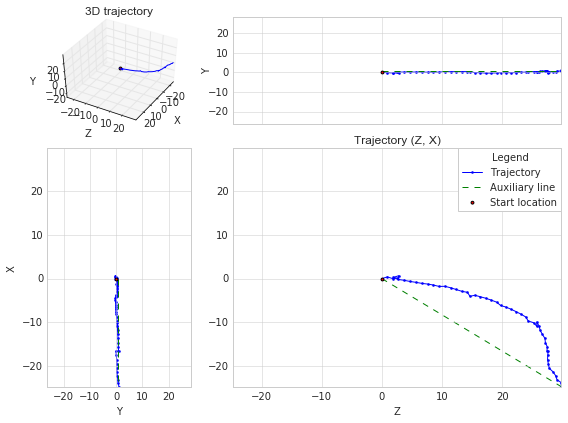

In [58]:
visualize_trajectory(trajectory)

Congrats on finishing this assignment! 